In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt

from IPython.display import display

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

from resnet import *

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
img_rows, img_cols, img_chns = 32, 32, 3
original_img_size = (img_rows, img_cols, img_chns)
num_classes = 10
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
decay = float(os.environ.get('DECAY', 0.0))
batch_size = int(os.environ.get('BATCH_SIZE', 250))
epochs = int(os.environ.get('EPOCHS', 100))
run_num = int(os.environ.get('RUN_NUM', 0))
use_preprocessing = int(os.environ.get('USE_PREPROCESSING', 1))

file_prefix = 'results_cifar10_preproc_%d_run_%d_' % (use_preprocessing, run_num)

# Load Data

In [4]:
(X_train_raw, y_train_raw), (X_test, y_test) = cifar10.load_data()
X_train_raw = X_train_raw / 255.
y_train_raw = keras.utils.to_categorical(y_train_raw, 10)
X_test = X_test / 255.
y_test = keras.utils.to_categorical(y_test, 10)

validation_index = int(len(X_train_raw) * 0.85)
X_validation, y_validation = X_train_raw[validation_index:], y_train_raw[validation_index:]
X_train, y_train = X_train_raw[:validation_index], y_train_raw[:validation_index]

print("raw", len(X_train_raw), len(y_train_raw))
print("validation", len(X_validation), len(y_validation))
print("train", len(X_train), len(y_train))
print("test", len(X_test), len(y_test))

raw 50000 50000
validation 7500 7500
train 42500 42500
test 10000 10000


In [5]:
# Augment data
if use_preprocessing:
    datagen = ImageDataGenerator(
        zoom_range=0.10,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='constant',
        rotation_range=10)
    datagen.fit(X_train)
          
    X_aug = [X_train]
    y_aug = [y_train]
    for i in range(2):
        X_gen, y_gen = next(datagen.flow(X_train,  y_train, batch_size=len(X_train)))
        X_aug.append(X_gen)
        y_aug.append(y_gen)
        
    X_train = np.concatenate(tuple(X_aug))
    y_train = np.concatenate(tuple(y_aug))
    del X_aug, y_aug, X_gen, y_gen
    print(X_train.shape, X_train.shape)

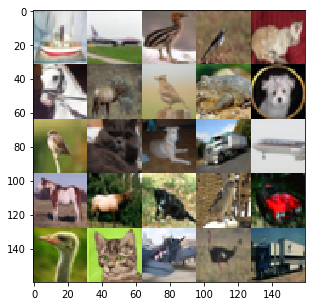

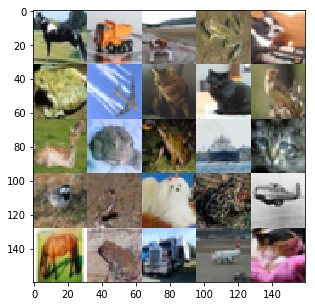

In [6]:
def display_grid(dataset, digit_size=32, grid_size=5, seed=None):
    # Display some digits to figure out what's going on
    figure = np.zeros((digit_size * grid_size, digit_size * grid_size, 3))
   
    if seed is not None:
        np.random.seed(seed)
    for i in range(grid_size):
        for j in range(grid_size):
            digit = dataset[np.random.randint(len(dataset))]
            d_x, d_y = i * digit_size, j * digit_size
            figure[d_x:d_x + digit_size, d_y:d_y + digit_size, :] = digit.astype(float)
            
    plt.figure(figsize=(5, 5))
    plt.imshow(figure)
    plt.show()

display_grid(X_train, seed=0)
display_grid(X_test, seed=0)

In [7]:
def make_model():
    x_input = Input(batch_shape=(None,) + original_img_size)
    resnet_model = ResNet50(weights=None, pooling='avg', input_shape=original_img_size, include_top=False)
    model_out = resnet_model(x_input)
    out = Dense(num_classes, activation='softmax', name='fc10')(model_out)
    model = Model(x_input, out, name='myresent50')
    return model

In [8]:
def train_model(model, y_train_vals):
    optimizer = Adam(lr=learning_rate, decay=decay)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    start = time.time()
    
    early_stopping = keras.callbacks.EarlyStopping('val_acc', min_delta=0.1, patience=20)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=10, min_lr=0.01 * learning_rate)
    
    callbacks=[early_stopping, reduce_lr]
    if 'CMDLINE' not in os.environ:
        callbacks += [TQDMNotebookCallback()]
        
    history = model.fit(
         X_train, y_train_vals,
         batch_size=batch_size,
         epochs=epochs,
         callbacks=callbacks,
         validation_data=(X_validation, y_validation),
         verbose=0
     )
    
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return model, history

In [9]:
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
fc10 (Dense)                 (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
# Testing
# epochs=1
# model, history = train_model(model, y_train)
# history.history

Iteration 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
fc10 (Dense)                 (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________
Elapsed:  1127.7665297985077


,val_loss,val_acc,loss,acc,lr
count,37.000000,37.000000,37.000000,37.000000,37.000000
mean,2.609779,0.443589,1.120593,0.619428,0.000805
std,3.012861,0.168104,0.246950,0.083412,0.000376
min,0.953743,0.099200,0.756679,0.347224,0.000100
0%,0.953743,0.099200,0.756679,0.347224,0.000100
25%,1.164515,0.349733,0.924717,0.572918,0.001000
50%,1.777268,0.443600,1.094086,0.617224,0.001000
75%,2.491652,0.610667,1.232115,0.684235,0.001000
95%,6.601858,0.666080,1.530392,0.722847,0.001000
99%,14.489748,0.671435,1.806669,0.734947,0.001000


10000/10000 [==============================] - 6s     
[1.6619586807250977, 0.512]
Iteration 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
fc10 (Dense)                 (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________
Elapsed:  1193.7983691692352


,val_loss,val_acc,loss,acc,lr
count,39.000000,39.000000,39.000000,39.000000,39.000000
mean,3.579967,0.339726,1.260366,0.683148,0.000908
std,3.466463,0.128830,0.172463,0.088997,0.000277
min,1.383260,0.095333,1.027004,0.451788,0.000100
0%,1.383260,0.095333,1.027004,0.451788,0.000100
25%,1.726932,0.235333,1.154508,0.643976,0.001000
50%,1.979755,0.374800,1.230138,0.693412,0.001000
75%,3.505062,0.448933,1.323101,0.744624,0.001000
95%,11.419042,0.506667,1.551137,0.816781,0.001000
99%,14.446472,0.509645,1.719995,0.820481,0.001000


10000/10000 [==============================] - 6s     
[1.5224355047225953, 0.5103]
Iteration 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
fc10 (Dense)                 (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________
Elapsed:  987.0966711044312


,val_loss,val_acc,loss,acc,lr
count,32.000000,32.000000,32.000000,32.000000,32.000000
mean,3.127284,0.333137,1.330030,0.700618,0.000803
std,2.082011,0.113447,0.123822,0.066245,0.000378
min,1.503680,0.120933,1.217728,0.442894,0.000100
0%,1.503680,0.120933,1.217728,0.442894,0.000100
25%,1.695467,0.247467,1.261549,0.681335,0.001000
50%,2.080149,0.363067,1.305685,0.713988,0.001000
75%,4.280262,0.412000,1.344858,0.740806,0.001000
95%,7.733488,0.482940,1.508542,0.768682,0.001000
99%,8.376744,0.487643,1.772746,0.780257,0.001000


10000/10000 [==============================] - 6s     
[1.5628108572006225, 0.489]


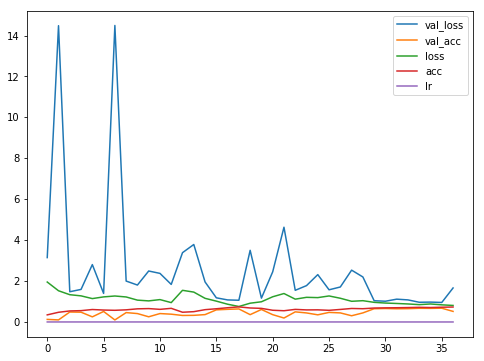

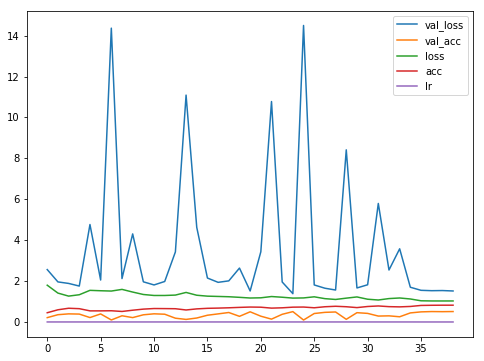

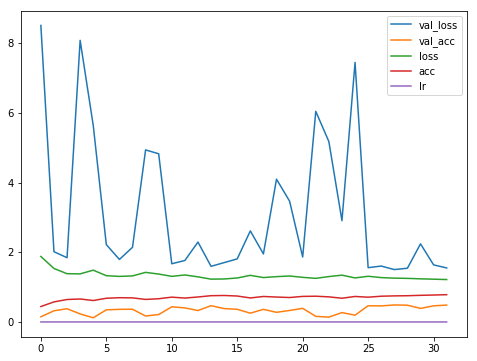

In [11]:
y_train_predict = y_train
for i in range(3):
    print("Iteration", i)
    model = make_model()
    model.summary()
    model, history = train_model(model, y_train_predict)
    
    df = pd.DataFrame(history.history)
    display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
    df.plot(figsize=(8, 6))
    df.to_csv(file_prefix + ('history_iter%d' % i) + '.csv', index=False)
    with open(file_prefix + 'vars.txt', 'w') as f:
        f.write(str(locals()))
    
    y_train_predict = model.predict(X_train)
    y_train_predict
    
    test_results = model.evaluate(X_test, y_test)
    print(test_results)
    with open('allresults.csv', 'a') as f:
        line = ','.join([str(use_preprocessing), str(run_num), str(i)] + [str(x) for x in test_results])
        f.write(line + '\n')

In [12]:
locals()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  "get_ipython().run_line_magic('load_ext', 'autoreload')\nget_ipython().run_line_magic('matplotlib', 'inline')\nget_ipython().run_line_magic('autoreload', '2')",
  'import numpy as np\nimport os\nimport time\nimport h5py\nimport keras\nimport pandas as pd\nimport math\nimport joblib\nimport json\nimport matplotlib.pyplot as plt\n\nfrom IPython.display import display\n\nfrom keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, \n                          Activation, Dropout, Conv2D, Conv2DTranspose,\n                          Concatenate, Add, Multiply)\nfrom keras.regularizers import l2\nfrom keras.initializers import RandomUniform\nfrom keras.optimizers import RMSprop, Adam, SGD\nfrom